# Skipception-200
Skipception-200 is a convolutional neural network constructed to classify 3x64x64px images across 200 different labels.

## Motivation
The primary goal of this project is to build a convolutional neural network architecture that leverages skip connections as described by He et al. (2015) in the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)" and inception blocks as detailed by Szegedy et al. (2014) in "[Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)" to classify 3x64x64 images across 200 labels.
 
Skip (shortcut) connections propagate information (identity) from one point in a convolutional neural network to a later point at which time it is added to the present state of the data. That is, the output of one layer is passed to layers deeper in the network through matrix addition.
 
These skip connections offer an alternative route for our gradients with backpropagation, aiding in the convergence of deep networks. This is one way to address the vanishing gradient problem. Additionally, skip connections allow for information captured earlier in the network to propagate forward into later parts of the network, preserving that earlier information to help inform the model's prediction. He et al. (2015) further notes that "Identity shortcut connections add neither extra parameter nor computational complexity."
 
Inception blocks were, at least in part, inspired by the need to address computational and memory inefficiencies of growing deep convolutional neural networks. In the implementation set out by Szegedy et al. (2014), three of the four inception module branches leverage 1x1, 1-Stride, 0-Padding convolutional blocks to aid in "judiciously applying dimension reductions and projections wherever the computational requirements would increase too much otherwise." They further cite the success of embeddings by which even low-dimensional embeddings may contain a relatively large amount of information. Szegedy et al. (2014) uses the 1x1 convolutional blocks in their implementation to reduce the input filter dimension before passing the data along to expensive 3x3 and 5x5 convolutions, a convention we follow in Skipception.
 
Our secondary goal is to build a model that learns the features of our data and generalizes reasonably well. For the purposes of this project, however, we will not continually explore architectures in search of the highest possible accuracy.

## Dataset Information
 
The dataset used for Skipception-200 is a modified version of [Tiny ImageNet](https://paperswithcode.com/dataset/tiny-imagenet). It contains 100,000 3x64x64 images for training, separated into 200 classes with 500 images per class. An additional 10,000 images, 50 per class, are reserved as a test set. The modifications made for this project includes slight directory adjustments.
 
[Download Tiny-ImageNet-200](https://github.com/jahjinx/ML_skipception/tree/main/datasets)

## Imports

In [ ]:
import os
import csv
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset, DataLoader

from sklearn.model_selection import train_test_split

## Check & Define Device


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## Build & Train Model

### Load Data

In [ ]:
# skip if local
from google.colab import drive 
drive.mount('/content/drive')

# change directory for local support in subesquent cells
%cd //content/drive/MyDrive/DS_projects/LD_copsForPortfolio/ML_skipception

Mounted at /content/drive
/content/drive/MyDrive/DS_projects/LD_copsForPortfolio/ML_skipception


Below, we unzip the dataset to Google Colab's temporary environment in order to resolve speed issues when accessing data directly from Google Drive.

In [ ]:
# unzip dataset
!unzip "datasets/tiny-imagenet-200.zip" -d "/content/tiny-imagenet-200" &> /dev/null

As we load the dataset, we define and apply a number of transforms to aid in recognition and generalization.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="/content/tiny-imagenet-200/train_set", 
                      transform=transform)

print(dataset)

Dataset ImageFolder
    Number of datapoints: 100000
    Root location: /content/tiny-imagenet-200/train_set
    StandardTransform
Transform: Compose(
               ToTensor()
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=[0.8, 1.2], hue=[-0.2, 0.2])
               RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
               RandomHorizontalFlip(p=0.5)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


When preparing the test data we experienced a discrepancy in the order classes were loaded and indexed. To ensure that the training and test data classes are mapped to the same indices, we call and export `dataset.class_to_idx` below to referencing when loading test data.

In [ ]:
print(dataset.class_to_idx)

# the following saves the class to index mapping for use in other notebooks
# it only really needs to be run once

class_to_idx = open("/datasets/class_to_idx-tiny-imagenet-200.pkl", "wb")

pickle.dump(dataset.class_to_idx, class_to_idx)

class_to_idx.close()

{'n01443537': 0, 'n01629819': 1, 'n01641577': 2, 'n01644900': 3, 'n01698640': 4, 'n01742172': 5, 'n01768244': 6, 'n01770393': 7, 'n01774384': 8, 'n01774750': 9, 'n01784675': 10, 'n01855672': 11, 'n01882714': 12, 'n01910747': 13, 'n01917289': 14, 'n01944390': 15, 'n01945685': 16, 'n01950731': 17, 'n01983481': 18, 'n01984695': 19, 'n02002724': 20, 'n02056570': 21, 'n02058221': 22, 'n02074367': 23, 'n02085620': 24, 'n02094433': 25, 'n02099601': 26, 'n02099712': 27, 'n02106662': 28, 'n02113799': 29, 'n02123045': 30, 'n02123394': 31, 'n02124075': 32, 'n02125311': 33, 'n02129165': 34, 'n02132136': 35, 'n02165456': 36, 'n02190166': 37, 'n02206856': 38, 'n02226429': 39, 'n02231487': 40, 'n02233338': 41, 'n02236044': 42, 'n02268443': 43, 'n02279972': 44, 'n02281406': 45, 'n02321529': 46, 'n02364673': 47, 'n02395406': 48, 'n02403003': 49, 'n02410509': 50, 'n02415577': 51, 'n02423022': 52, 'n02437312': 53, 'n02480495': 54, 'n02481823': 55, 'n02486410': 56, 'n02504458': 57, 'n02509815': 58, 'n0266

In [ ]:
batch = 64

# define indicies so that we can stratify our splits
train_indices, val_indices, _, _ = train_test_split(
    range(len(dataset)),
    dataset.targets,
    stratify=dataset.targets,
    test_size=0.2,
    random_state=0
)

# create subset with indices
train_split = Subset(dataset, train_indices)
val_split = Subset(dataset, val_indices)

# create batch loaders
train_batches = DataLoader(train_split, 
                           batch_size=batch, 
                           shuffle=True)

val_batches = DataLoader(val_split, 
                          batch_size=batch, 
                          shuffle=False)
# Report split sizes
print('Training batch has {} instances'.format(len(train_batches)))
print('Validation batch has {} instances'.format(len(val_batches)))

Training batch has 1250 instances
Validation batch has 313 instances


### View Data

In [ ]:
# link class names to mapped index for viewing
class_names = {} 

# open txt file and read lines
mapping = open('/content/tiny-imagenet-200/words.txt', 'r')
lines = mapping.readlines()

# split lines and save to respective dicts
# mapping id/name to index as prediction outputs will be in 0-n format
for i, line in enumerate(lines):
  class_names[line.split('\t')[0]] = line.split('\t')[1]

class_names = {k:v.strip() for (k, v) in class_names.items()}

In [ ]:
class_name_to_idx = {dataset.class_to_idx[k]:v for (k, v) in class_names.items()}
print(class_name_to_idx)

{0: 'goldfish, Carassius auratus', 1: 'European fire salamander, Salamandra salamandra', 2: 'bullfrog, Rana catesbeiana', 3: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 4: 'American alligator, Alligator mississipiensis', 5: 'boa constrictor, Constrictor constrictor', 6: 'trilobite', 7: 'scorpion', 8: 'black widow, Latrodectus mactans', 9: 'tarantula', 10: 'centipede', 11: 'goose', 12: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 13: 'jellyfish', 14: 'brain coral', 15: 'snail', 16: 'slug', 17: 'sea slug, nudibranch', 18: 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 19: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 20: 'black stork, Ciconia nigra', 21: 'king penguin, Aptenodytes patagonica', 22: 'albatross, mollymawk', 23: 'dugong, Dugong dugon', 24: 'Chihuahua', 25: 'Yorkshire terrier', 26: 'golden retriever', 27: 'Labrador retriever', 28: 'German shepherd, German shepherd dog, G

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


84: cannon
99: drumstick
69: bathtub, bathing tub, bath, tub
151: space heater
58: lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
94: convertible


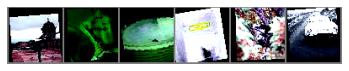

In [ ]:
# helper function for inline image display
def matplotlib_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_batches)
images, labels = dataiter.next()

# create a grid from the images and display
img_grid = torchvision.utils.make_grid(images[0:6])
matplotlib_imshow(img_grid)
for j in range(6):
  print(f"{int(labels[j])}: {class_name_to_idx[int(labels[j])]}")

### Define Network

![](https://drive.google.com/uc?id=1PLJSG-_9nUG2175qZ08YNMEO3dqNj4Pi)

[Enlarge Schematic](https://drive.google.com/file/d/1PLJSG-_9nUG2175qZ08YNMEO3dqNj4Pi/view?usp=sharing)

Below, we define several blocks before creating our model:
 
**`conv_block`** : a basic convolutional module that passes our data through a convolution with the defined parameters, then batchnorm and relu activation.
 
&nbsp;&nbsp;&nbsp;&nbsp;`in_channels` : number of input channels for `nn.Conv2d` <br />
&nbsp;&nbsp;&nbsp;&nbsp;`out_channels` : number of output channels for `nn.Conv2d` <br />
&nbsp;&nbsp;&nbsp;&nbsp;`**kwargs` : additional supported arguments for `nn.Conv2d` such as `kernel_size` and `padding`<br /><br />
 
 
**`inception_block`** : An inception module with dimension reductions as described by He et al. (2015).
 
&nbsp;&nbsp;&nbsp;&nbsp;`in_channels` : number of input channels to the first blocks of our module's four branches:<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- three 1x1 `conv_block`<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- one 3x3 `nn.MaxPool2d` layer<br />
&nbsp;&nbsp;&nbsp;&nbsp;`out_1x1` : number of output channels for our `branch_1` convolutional block <br />
&nbsp;&nbsp;&nbsp;&nbsp;`red_3x3` : number of input channels to the second convolutional block in `branch_2` — a 3x3 `conv_block`<br />
&nbsp;&nbsp;&nbsp;&nbsp;`out_3x3` : number of output channels from the second convolutional block in `branch_2`<br />
&nbsp;&nbsp;&nbsp;&nbsp;`red_5x5` : number of input channels to the second convolutional block in `branch_3` — a 5x5 `conv_block`<br />
&nbsp;&nbsp;&nbsp;&nbsp;`out_5x5` : number of output channels from the second convolutional block in `branch_3` <br />
&nbsp;&nbsp;&nbsp;&nbsp;`out_1x1_pool` : number of output channels from the convolutional block in `branch_4`<br /><br />
 
**`skipception_block`**  : A skip connection comprised of two `inception_block`. The identity is preserved and passed along to the output of the second `inception_block`. The `skipception_block` takes `in_channels`, `red_3x3`, and `red_5x5` as defined above then calculates the size of output channels that will ensure that the shape of our `inception2` output matches the shape of our identity for element-wise addition.  This "automatic" method was used to save time and it is likely a more considered selection of parameters would perform better.

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(self.batchnorm(x))
        return x

class inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1_pool):
        super().__init__()
        
        self.branch_1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch_2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        self.branch_3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        self.branch_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1_pool, kernel_size=1)
        )

    def forward(self, x):
        return torch.cat([self.branch_1(x), self.branch_2(x), self.branch_3(x), self.branch_4(x)], 1)

class skipception_block(nn.Module):
    def __init__(self, in_channels, red_3x3, red_5x5):
        super().__init__()

        self.relu = nn.ReLU()

        inception: int(in_channels, red_3x3, red_5x5)
        out_1x1 = int(in_channels/4)
        out_3x3 = int(in_channels/2)
        out_5x5 = int(in_channels/8)
        out_1x1_pool = int(in_channels/8)

        red_3x3_2 = int(red_3x3*1.25)
        red_5x5_2 = int(red_5x5*1.75)

        self.inception1 = inception_block(in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1_pool)
        self.inception2 = inception_block(in_channels, out_1x1, red_3x3_2, out_3x3, red_5x5_2, out_5x5, out_1x1_pool)

    def forward(self, x):
        identity = x

        x = self.inception1(x)
        x = self.inception2(x)

        out = identity + x

        out = self.relu(out)

        return out

class Classifier_Skipception(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__( )
        
        self.relu = nn.ReLU()

        self.conv1 = conv_block(in_channels=3, out_channels=32, kernel_size=7, padding='same')
        self.conv2 = conv_block(in_channels=32, out_channels=64, kernel_size=5, padding='same')         
        self.conv3 = conv_block(in_channels=64, out_channels=128, kernel_size=3, padding='same')         
        
        # inception skip, input size from previous layer,
        # output from inception skip must eqal in_channels
        # inception: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1_pool
        self.inception1 = inception_block(128, 64, 64, 64, 96, 64, 64)
        self.skipception1 = skipception_block(256, 64, 128)

        self.inception2 = inception_block(256, 128, 128, 128, 192, 128, 128)
        self.skipception2 = skipception_block(512, 128, 256)


        self.max_pool = nn.MaxPool2d(3, 2)
        self.avg_pool = nn.AvgPool2d(7, 1)

        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(512*1*1, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.max_pool(x)

        x = self.inception1(x)
        x = self.skipception1(x)
        x = self.max_pool(x)

        x = self.inception2(x)
        x = self.skipception2(x) 
        x = self.max_pool(x)

        x = self.avg_pool(x)

        x = x.reshape(x.size(0), -1) # flatten the input
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Instantiate Model

In [ ]:
model = Classifier_Skipception()

In [ ]:
model.to(device)

Classifier_Skipception(
  (relu): ReLU()
  (conv1): conv_block(
    (relu): ReLU()
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (inception1): inception_block(
    (branch_1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch_2): Sequential(
      (0): conv_block

### Train Model
Below, we define some functions that will aid in training, including a `save_model` function that allows us to define a save frequencey. This will allow us to drop/continue training in subesequent sessions or assess different stages of training.

In [ ]:
def validate(model, val_dl, loss_fn):
  model.eval()
  val_loss = 0.0
  num_val_correct = 0
  num_val_examples = 0

  with torch.no_grad():
    for batch in val_dl:
      x    = batch[0].to(device)
      y    = batch[1].to(device)
      yhat = model(x)
      loss = loss_fn(yhat, y)

      val_loss         += loss.data.item() * x.size(0)
      num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
      num_val_examples += y.shape[0]

  val_acc  = num_val_correct / num_val_examples
  val_loss = val_loss / len(val_dl.dataset)

  return val_acc, val_loss

def save_model(epoch, history, save_dir=None, save_filename=None, save_freq=20):
  if save_dir != None and ((epoch)%save_freq == 0):
    
    results_path = os.path.join(save_dir, f'{save_filename}_ep{epoch}.pt')

    state = {'epoch': epoch, 
             'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'history': history
              }

    try:
      torch.save(state, results_path)
      print(f'Model @ epoch {epoch} saved to {results_path}')
      
    except Exception:
      print(f'Model @ epoch {epoch} not saved')
      pass

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu', 
          save_dir=None, save_filename=None, save_freq=20):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s, save_dir=%s%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device, save_dir, save_filename))

    history = {} # Collects per-epoch loss and acc
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        val_acc, val_loss = validate(model, val_dl, loss_fn)

        if epoch == 1 or epoch % 1 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)
    
        # ----------- SAVE -----------
        save_model(epoch, history, save_dir, save_filename, save_freq)

    # END OF TRAINING LOOP

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [ ]:
# define Loss Function and Optimizer
epochs = 150
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
save_dir = 'saved_models/'
save_filename = 'skipception_TI-200'
save_freq = 20

# train
history = train(model, optimizer, loss_fn, train_batches, val_batches, epochs, 
                device, save_dir, save_filename, save_freq)

train() called: model=Classifier_Skipception, opt=SGD(lr=0.001000), epochs=150, device=cuda:0, save_dir=saved_models/skipception_TI-200

Epoch   1/150, train loss:  5.10, train acc:  0.02, val loss:  4.84, val acc:  0.04
Epoch   2/150, train loss:  4.62, train acc:  0.05, val loss:  4.38, val acc:  0.08
Epoch   3/150, train loss:  4.30, train acc:  0.09, val loss:  4.21, val acc:  0.10
Epoch   4/150, train loss:  4.10, train acc:  0.11, val loss:  3.95, val acc:  0.13
Epoch   5/150, train loss:  3.94, train acc:  0.13, val loss:  3.82, val acc:  0.15
Epoch   6/150, train loss:  3.80, train acc:  0.15, val loss:  3.76, val acc:  0.16
Epoch   7/150, train loss:  3.69, train acc:  0.17, val loss:  3.56, val acc:  0.19
Epoch   8/150, train loss:  3.58, train acc:  0.18, val loss:  3.47, val acc:  0.20
Epoch   9/150, train loss:  3.49, train acc:  0.20, val loss:  3.35, val acc:  0.23
Epoch  10/150, train loss:  3.40, train acc:  0.21, val loss:  3.29, val acc:  0.24
Epoch  11/150, train lo

### Metrics
Viewing the Training/Validation Accuracy/Loss charts below, we find our model's validation accuracy plateaus at 80-100 epochs and the validation loss begins increasing within the same range. We are likely to see the best generalization from our model at around epoch 90.

In [ ]:
# ----------- LOAD -----------
results_path = 'saved_models/skipception_TI-200_ep140.pt'
checkpoint = torch.load(results_path)
history = checkpoint['history']

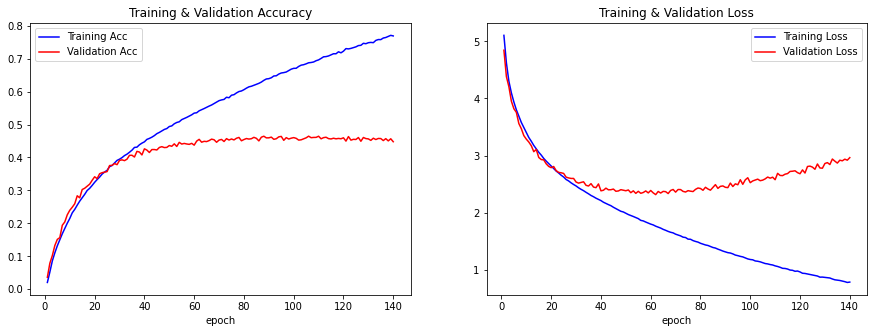

In [ ]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(epochs, acc, 'b', label='Training Acc')
axs[0].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[0].set_title('Training & Validation Accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend()

# plot Training & Validation Loss
axs[1].plot(epochs, loss, 'b', label='Training Loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axs[1].set_title('Training & Validation Loss')
axs[1].set_xlabel('epoch')
axs[1].legend()

plt.show()

## Test on Test Data

### Load Test Data
In the following cells, we write a custom dataset class to load our test images along with their classes and the proper index for each class. This class will work with the Pytorch DataLoader. We will also print some details and a sample image from the test dataset to ensure everything is working as expected.

In [ ]:
# define dataset class to properly load test set with labels
class ImageMap(Dataset):
  def __init__(self, root_dir, label_txt_file, class_to_idx, transform=None):
      self.root_dir = root_dir # location of images folder
      self.label_txt_file = label_txt_file # filename for true label/image map
      self.class_to_idx = class_to_idx

      # open and read label text file
      self.label_open = open(f"{self.root_dir}/{label_txt_file}", 'r')
      self.lines = self.label_open.readlines()
      # split lines, get image file name
      self.image_filenames = [line.split('\t')[0] for line in self.lines]
      # split lines, get true image labels
      self.image_labels = [line.split('\t')[1] for line in self.lines]

      # set transform
      self.transform = transform

  def __len__(self):
          return len(self.image_labels)

  def __getitem__(self, idx):
          # get one label by index
          label_name = self.image_labels[idx]

          # us this to map class to index as from training
          label_mapping = torch.as_tensor(self.class_to_idx[label_name])

          # define one image directory and open as PIL image
          img_dir = f"{self.root_dir}/images/{self.image_filenames[idx]}"
          with open(img_dir, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')

          # transform if transforms defined
          if self.transform is not None:
            img = self.transform(img)

          return img, label_mapping

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageMap('/content/tiny-imagenet-200/test_set', 'test_labels.txt', 
                        dataset.class_to_idx,
                        transform=transform)

In [ ]:
batch = 1

test_batches = DataLoader(test_dataset, 
                          batch_size=batch, 
                          shuffle=False)

In [ ]:
len(test_batches)

10000

### View Test Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


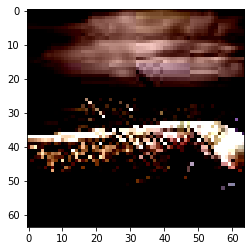

In [ ]:
plt.imshow(test_dataset[1][0].permute(1, 2, 0))

### Load Model @ Desired Epoch
As indicated by our training data above, the best model to load and test is likely our 100-epoch model. Several tests have confirmed that the 100-epoch model generalizes best on this dataset. We have kept that evaluation below.
 



In [ ]:
# ----------- LOAD -----------
results_path = 'saved_models/skipception_TI-200_ep100.pt'

model = Classifier_Skipception()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load(results_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
model.to(device)

Classifier_Skipception(
  (relu): ReLU()
  (conv1): conv_block(
    (relu): ReLU()
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (inception1): inception_block(
    (branch_1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch_2): Sequential(
      (0): conv_block

### Generate Predictions & Evaluate
After generating our predictions and evaluating based on accuracy, we learn our model's final score: .49. As noted in the introduction to this project, the primary intent was not to find an architecture that scores as high as possible but rather to build a reasonably sized model that utilizes both skip connections and inception. Regardless, we find that our model is fairly capable of learning the features of our image dataset. Considering a random guess across 200 classes, we would expect an accuracy of about .005 in contrast to our model's accuracy of .49.

In [ ]:
# --- EVALUATE ON VALIDATION SET -------------------------------------
model.eval()
num_test_correct  = 0
num_test_examples = 0
preds = []
trues = []

with torch.no_grad():
  for batch in test_batches:
      # print(x.shape)
      x    = batch[0].to(device)
      y    = batch[1].to(device)
      yhat = model(x)

      preds.append(torch.max(yhat, 1)[1].item())
      trues.append(y[0].item())

      num_test_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
      num_test_examples += y.shape[0]

  test_acc  = num_test_correct / num_test_examples

print(preds)
print(trues)
print(test_acc)

[107, 139, 110, 69, 102, 161, 147, 72, 145, 43, 53, 192, 39, 131, 13, 100, 33, 89, 87, 119, 60, 124, 119, 39, 170, 141, 171, 130, 28, 25, 107, 177, 129, 149, 99, 140, 6, 173, 2, 127, 148, 33, 44, 199, 110, 122, 4, 184, 53, 80, 9, 34, 39, 15, 75, 199, 10, 79, 66, 15, 117, 177, 25, 101, 102, 102, 118, 101, 0, 95, 160, 106, 199, 113, 42, 136, 30, 102, 187, 16, 53, 23, 85, 109, 176, 25, 199, 20, 21, 35, 163, 23, 172, 63, 129, 55, 30, 79, 157, 145, 123, 40, 45, 188, 110, 36, 194, 101, 32, 151, 174, 172, 193, 65, 160, 53, 63, 101, 38, 167, 98, 47, 149, 50, 73, 172, 196, 164, 163, 76, 2, 190, 120, 165, 185, 155, 95, 172, 34, 117, 170, 15, 94, 63, 24, 75, 74, 88, 120, 30, 91, 187, 169, 121, 55, 111, 51, 173, 64, 59, 174, 184, 14, 54, 162, 63, 181, 67, 75, 137, 102, 162, 164, 159, 120, 78, 55, 112, 142, 144, 9, 115, 46, 172, 149, 113, 158, 57, 41, 112, 120, 13, 8, 150, 83, 100, 171, 122, 161, 58, 53, 169, 176, 68, 104, 9, 76, 121, 13, 98, 132, 11, 166, 66, 71, 163, 155, 176, 30, 174, 9, 115, 18

## Network Overview
Below, we take a top-down look at the architecture of our model using `torchsummary`. We can also see our model size as well as details on the number of trainable parameters.
 
As a point of reference, we consider GoogleNet which classifies 3x224x224 images with 7 million parameters whereas Skipception has around 4.5 million parameters. However, we will not explore a more in-depth comparison at this time.

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 64, 64), batch_size=64, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 64, 64]           4,736
       BatchNorm2d-2           [64, 32, 64, 64]              64
              ReLU-3           [64, 32, 64, 64]               0
        conv_block-4           [64, 32, 64, 64]               0
            Conv2d-5           [64, 64, 64, 64]          51,264
       BatchNorm2d-6           [64, 64, 64, 64]             128
              ReLU-7           [64, 64, 64, 64]               0
        conv_block-8           [64, 64, 64, 64]               0
            Conv2d-9          [64, 128, 64, 64]          73,856
      BatchNorm2d-10          [64, 128, 64, 64]             256
             ReLU-11          [64, 128, 64, 64]               0
       conv_block-12          [64, 128, 64, 64]               0
        MaxPool2d-13          [64, 128, 31, 31]               0
           Conv2d-14           [64, 64,